## Data Extraction

In [ ]:
#extracting data from Reddit using PRAW s
import praw
import csv
import time
from datetime import datetime, timedelta

#Set up Reddit client 
def reddit_client():
    return praw.Reddit(
        client_id="Gu1MvROe_qBoXnqnbjNRWg",
        client_secret="g8FgCM9IspBFAq9YZqgdgQ-a9CDrbA",
        user_agent="client for SNAM2024"
    )

client = reddit_client()

# Parameters
subreddits = ['SabrinaCarpenter', 'popheads','Fauxmoi']
year = 2022
output_file = f"sabrina_reddit_{year}_full.csv"

# Create time windows (weekly)
start_date = datetime(year, 1, 1)
end_date = datetime(year, 12, 31)
time_window = timedelta(days=7)

# Storage for all data
posts_data = []

# Main loop: week by week
while start_date < end_date:
    end_window = start_date + time_window
    start_ts = int(start_date.timestamp())
    end_ts = int(end_window.timestamp())

    print(f"Scraping posts from {start_date.date()} to {end_window.date()}")

    for sub in subreddits:
        subreddit = client.subreddit(sub)

        try:
            for post in subreddit.new(limit=1000):
                if start_ts <= post.created_utc <= end_ts:
                    base = {
                        'subreddit': sub,
                        'post_id': post.id,
                        'post_title': post.title,
                        'post_author': str(post.author) if post.author else 'deleted',
                        'post_score': post.score,
                        'post_created_utc': post.created_utc,
                        'post_created_utc_readable': datetime.utcfromtimestamp(post.created_utc).strftime('%Y-%m-%d %H:%M:%S'),
                        'post_num_comments': post.num_comments,
                        'post_selftext': post.selftext,
                        'post_flair': post.link_flair_text,
                        'comment_id': '',
                        'comment_author': '',
                        'comment_body': '',
                        'comment_score': '',
                        'comment_created_utc': '',
                        'comment_created_utc_readable': '',
                        'comment_flair': ''
                    }

                    try:
                        post.comments.replace_more(limit=0)
                        for comment in post.comments.list():
                            comment_data = base.copy()
                            comment_data.update({
                                'comment_id': comment.id,
                                'comment_author': str(comment.author) if comment.author else 'deleted',
                                'comment_body': comment.body,
                                'comment_score': comment.score,
                                'comment_created_utc': comment.created_utc,
                                'comment_created_utc_readable': datetime.utcfromtimestamp(comment.created_utc).strftime('%Y-%m-%d %H:%M:%S'),
                                'comment_flair': comment.author_flair_text
                            })
                            posts_data.append(comment_data)
                    except Exception as e:
                        print(f"Error in comments: {e}")
                        continue

        except Exception as e:
            print(f"Subreddit error: {e}")
            continue

    # Move to the next week
    start_date = end_window
    time.sleep(1)

# Save to CSV
if posts_data:
    with open(output_file, 'w', encoding='utf-8', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=posts_data[0].keys())
        writer.writeheader()
        writer.writerows(posts_data)

    print(f"Saved {len(posts_data)} rows to {output_file}")
else:
    print("No data collected.")


/Users/anjalysajeevkumar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [8]:
if start_ts <= post.created_utc <= end_ts:
    print(f"Found post: {post.title} at {datetime.utcfromtimestamp(post.created_utc)}")


In [16]:
import praw
from datetime import datetime

reddit = praw.Reddit(
    client_id="Gu1MvROe_qBoXnqnbjNRWg",
    client_secret="g8FgCM9IspBFAq9YZqgdgQ-a9CDrbA",
    user_agent="client for SNAM2024"
)

subreddit_name = "Music"
start_ts = int(datetime(2019, 1, 1).timestamp())
end_ts = int(datetime(2019, 12, 31, 23, 59, 59).timestamp())

subreddit = reddit.subreddit(subreddit_name)
count = 0

for post in subreddit.new(limit=1000):
    if start_ts <= post.created_utc <= end_ts:
        count += 1

print(f"Found {count} posts in {subreddit_name} for 2019.")


✅ Found 0 posts in Music for 2019.


### Network Analysis

In [34]:
import pandas as pd
import networkx as nx

# loading Preprocessed dataset
df = pd.read_csv("sabrina_cleaned_combined.csv", encoding='ISO-8859-1', sep=None, engine="python")
# Drop rows where comment_author or post_author is missing or deleted
df = df[
    df['comment_author'].notna() &
    df['post_author'].notna() &
    ~df['comment_author'].str.lower().isin(['[deleted]', 'deleted']) &
    ~df['post_author'].str.lower().isin(['[deleted]', 'deleted'])
]

# Also drop rows with missing parent_comment_author (optional)
# Only if you want to ensure all edges are between valid users
if 'parent_comment_author' in df.columns:
    df = df[
        df['parent_comment_author'].notna() &
        ~df['parent_comment_author'].str.lower().isin(['[deleted]', 'deleted'])
    ]



In [35]:
import pandas as pd
import networkx as nx



# Setup Graph
G = nx.DiGraph()

# Choose Correct Column Names
text_col = 'cleaned_text' if 'cleaned_text' in df.columns else None
year_col = 'year' if 'year' in df.columns else None

# Build the Graph
for _, row in df.iterrows():
    source = str(row['comment_author']).strip().lower()

    if pd.notnull(row.get('parent_comment_author')):
        target = str(row['parent_comment_author']).strip().lower()
    elif pd.notnull(row.get('post_author')):
        target = str(row['post_author']).strip().lower()
    else:
        continue

    if source and target and source != target:
        G.add_edge(source, target,
                   text=row[text_col] if text_col else '',
                   subreddit=row.get('subreddit', ''),
                   year=row.get(year_col, ''))

# Save to GraphML (for Gephi)
nx.write_graphml(G, "user_interaction_graph.graphml")

# Print Summary
print(f"Graph created: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")



✅ Graph created: 7921 nodes, 13600 edges


In [36]:
import networkx as nx


# G = nx.read_graphml("user_interaction_graph.graphml")

# Degree Centrality 
degree_centrality = nx.degree_centrality(G)
in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())

# PageRank
pagerank = nx.pagerank(G)

# Top N users by metric
N = 10

print("\nTop Users by Degree Centrality:")
for user, score in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:N]:
    print(f"{user:<20} — {score:.4f}")

print("\nTop Users by PageRank:")
for user, score in sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:N]:
    print(f"{user:<20} — {score:.6f}")

print("\nTop Users by In-Degree (most replied to):")
for user, deg in sorted(in_degree.items(), key=lambda x: x[1], reverse=True)[:N]:
    print(f"{user:<20} — {deg} replies")

print("\nTop Users by Out-Degree (most active commenters):")
for user, deg in sorted(out_degree.items(), key=lambda x: x[1], reverse=True)[:N]:
    print(f"{user:<20} — {deg} comments")



🔝 Top Users by Degree Centrality:
springtimecarnivore  — 0.1303
georgeneleggett      — 0.0872
king81arthur         — 0.0777
enburgi              — 0.0591
mcfw31               — 0.0564
hekna02              — 0.0466
wadewilson9012       — 0.0429
prize_sky754         — 0.0361
impeccabletim        — 0.0354
3kolen               — 0.0352

🔝 Top Users by PageRank:
springtimecarnivore  — 0.044896
king81arthur         — 0.040849
big-ambitions-8258   — 0.038759
georgeneleggett      — 0.031327
impeccabletim        — 0.026511
mcfw31               — 0.022862
enburgi              — 0.017052
northern89lights     — 0.016580
augggie              — 0.014515
purplespacesurfer    — 0.011955

🔝 Top Users by In-Degree (most replied to):
springtimecarnivore  — 1031 replies
georgeneleggett      — 689 replies
king81arthur         — 615 replies
enburgi              — 451 replies
mcfw31               — 443 replies
hekna02              — 355 replies
wadewilson9012       — 340 replies
prize_sky754         — 286 r

In [37]:
!pip3 install python-louvain


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [38]:
import pandas as pd
import networkx as nx
import community as community_louvain  # this is the python-louvain package

# Load your existing graph
G = nx.read_graphml("user_interaction_graph.graphml")

# Run Louvain community detection
partition = community_louvain.best_partition(G.to_undirected())

# Assign community ID as node attribute
nx.set_node_attributes(G, partition, "community")

# Save graph with communities for Gephi
nx.write_graphml(G, "user_interaction_graph_with_communities.graphml")

# Print number of communities
num_communities = len(set(partition.values()))
print(f"Detected {num_communities} communities using Louvain method.")


✅ Detected 125 communities using Louvain method.


In [39]:
pd.DataFrame(partition.items(), columns=["user", "community"]).to_csv("node_communities.csv", index=False)


In [40]:
import networkx as nx
import pandas as pd

# Load Graph
G = nx.read_graphml("user_interaction_graph_with_communities.graphml")

# Get community attribute
communities = nx.get_node_attributes(G, "community")

# Choose a centrality metric
pagerank = nx.pagerank(G)
# or use degree centrality: degree_centrality = nx.degree_centrality(G)

# Build DataFrame
data = []
for node in G.nodes():
    data.append({
        "user": node,
        "community": communities.get(node),
        "pagerank": pagerank.get(node, 0),
        "degree": G.degree(node)
    })

df = pd.DataFrame(data)

# Get Top N Nodes per Community
N = 10
top_nodes_per_community = (
    df.sort_values(by="pagerank", ascending=False)
      .groupby("community")
      .head(N)
      .reset_index(drop=True)
)

# Save to CSV or View
top_nodes_per_community.to_csv("top_users_by_community.csv", index=False)
print("Top users per community saved to top_users_by_community.csv")

# Optional: display first few rows
print(top_nodes_per_community.head(20))


✅ Top users per community saved to top_users_by_community.csv
                   user  community  pagerank  degree
0   springtimecarnivore         29  0.044896    1032
1          king81arthur          2  0.040849     615
2    big-ambitions-8258         26  0.038759      20
3       georgeneleggett          2  0.031327     691
4         impeccabletim         33  0.026511     280
5                mcfw31         24  0.022862     447
6               enburgi         26  0.017052     468
7      northern89lights          2  0.016580     126
8               augggie          8  0.014515     266
9     purplespacesurfer         15  0.011955     220
10   zealousidealarm160         35  0.011921     253
11     daydream_machine          8  0.011283     143
12             racloves         19  0.010775     139
13       wadewilson9012          1  0.010374     340
14              hekna02         11  0.010363     369
15         prize_sky754         30  0.009224     286
16               frajer          8  0

In [48]:
import networkx as nx
import pandas as pd
from textblob import TextBlob
from collections import defaultdict

# Load your graph
G = nx.read_graphml("user_interaction_graph_with_communities.graphml")

# Assign sentiment to edges safely
for u, v, d in G.edges(data=True):
    raw_text = d.get("text", "")
    text = str(raw_text) if pd.notnull(raw_text) else ""
    sentiment = TextBlob(text).sentiment.polarity if text.strip() else 0.0
    G[u][v]["sentiment"] = sentiment

# Group sentiment by source node's community
node_community = nx.get_node_attributes(G, "community")
community_sentiments = defaultdict(list)

for u, v, d in G.edges(data=True):
    comm = node_community.get(u)
    if comm is not None:
        community_sentiments[comm].append(d.get("sentiment", 0.0))

# Compute average sentiment per community
rows = []
for comm, scores in community_sentiments.items():
    avg_sent = sum(scores) / len(scores) if scores else 0.0
    rows.append({"community": comm, "average_sentiment": avg_sent, "num_edges": len(scores)})

sentiment_df = pd.DataFrame(rows).sort_values(by="average_sentiment", ascending=False)

# Save and display
sentiment_df.to_csv("community_sentiment_comparison.csv", index=False)
print("Sentiment comparison saved to community_sentiment_comparison.csv")
print(sentiment_df)


✅ Sentiment comparison saved to community_sentiment_comparison.csv
     community  average_sentiment  num_edges
84          95           0.683333          1
69          79           0.550000          1
67          77           0.500000          1
6            7           0.350000          1
54          64           0.231401          1
..         ...                ...        ...
124         52           0.000000          1
95         106          -0.100000          1
93         104          -0.125000          1
103        114          -0.200000          1
40          48          -0.400000          1

[125 rows x 3 columns]


In [49]:
import pandas as pd

# Load your sentiment data
df = pd.read_csv("community_sentiment_comparison.csv")

# Define classification function
def classify_sentiment(score):
    if score > 0.2:
        return "Positive"
    elif score > 0.05:
        return "Mildly Positive"
    elif score >= -0.05:
        return "Neutral"
    elif score >= -0.2:
        return "Mildly Negative"
    else:
        return "Negative"

# Apply classification
df["sentiment_label"] = df["average_sentiment"].apply(classify_sentiment)

# Save with labels
df.to_csv("classified_community_sentiment.csv", index=False)
print("Saved as classified_community_sentiment.csv")
print(df[["community", "average_sentiment", "sentiment_label", "num_edges"]])


✅ Saved as classified_community_sentiment.csv
     community  average_sentiment  sentiment_label  num_edges
0           95           0.683333         Positive          1
1           79           0.550000         Positive          1
2           77           0.500000         Positive          1
3            7           0.350000         Positive          1
4           64           0.231401         Positive          1
..         ...                ...              ...        ...
120         52           0.000000          Neutral          1
121        106          -0.100000  Mildly Negative          1
122        104          -0.125000  Mildly Negative          1
123        114          -0.200000  Mildly Negative          1
124         48          -0.400000         Negative          1

[125 rows x 4 columns]


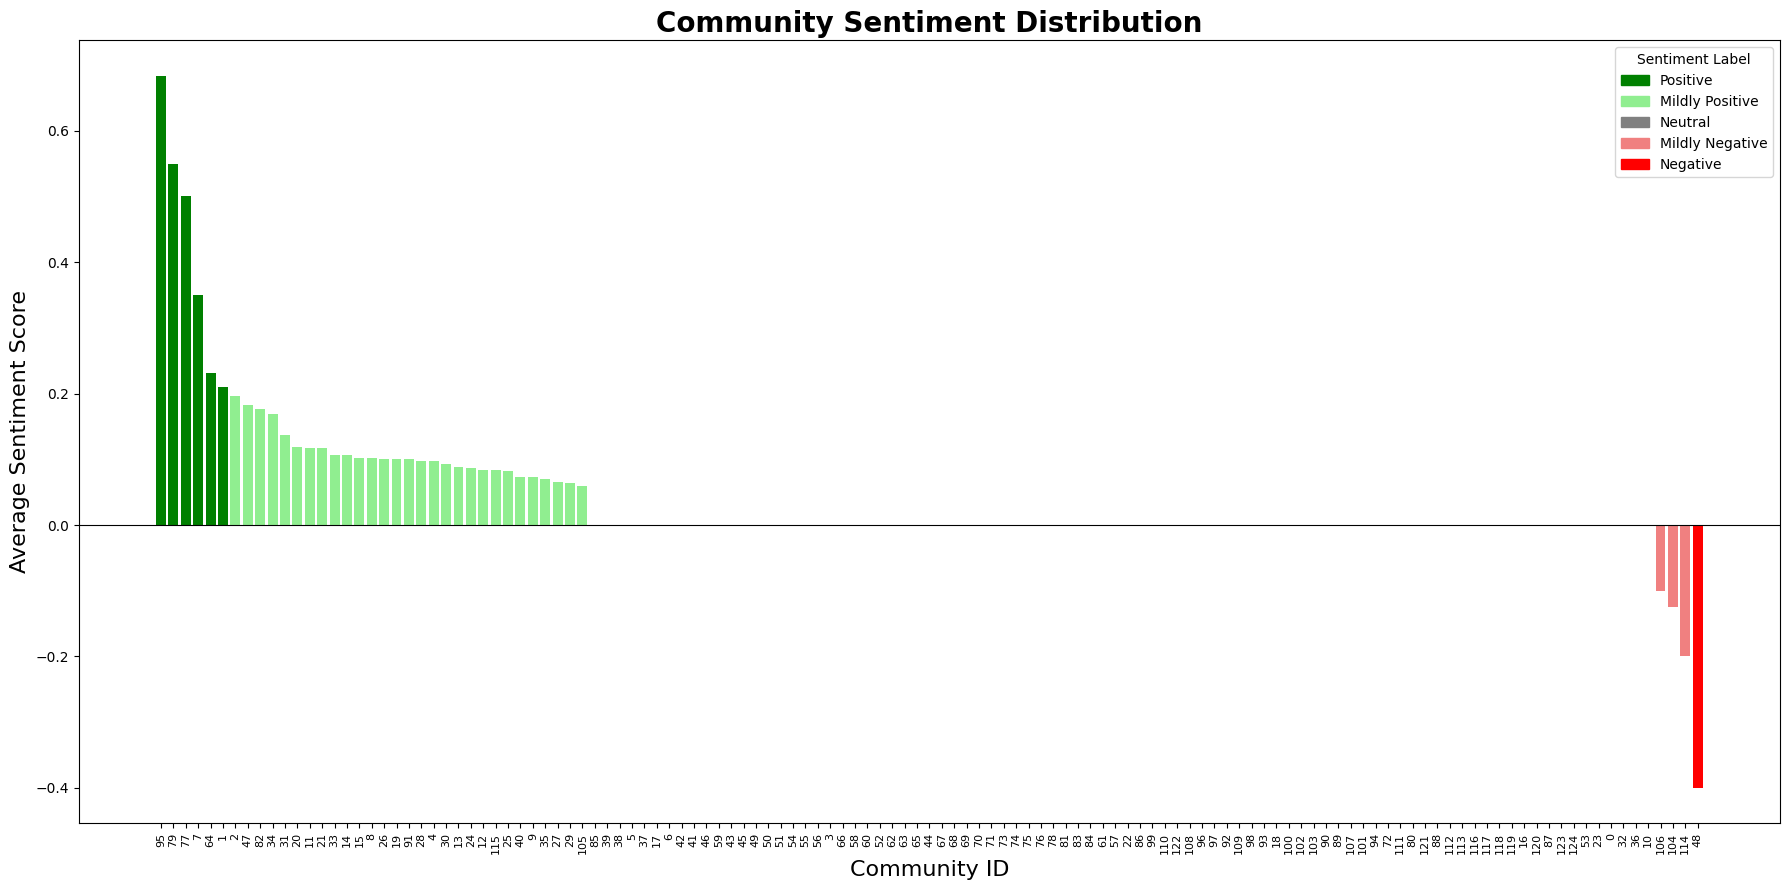

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load the sentiment data
df = pd.read_csv('classified_community_sentiment.csv')

# Sort by average sentiment for better visualization
df_sorted = df.sort_values(by='average_sentiment', ascending=False)

# Set colors based on sentiment label
def get_color(sentiment):
    if sentiment == "Positive":
        return 'green'
    elif sentiment == "Mildly Positive":
        return 'lightgreen'
    elif sentiment == "Neutral":
        return 'gray'
    elif sentiment == "Mildly Negative":
        return 'lightcoral'
    else:  # Negative
        return 'red'

colors = df_sorted['sentiment_label'].apply(get_color)

# Plot
plt.figure(figsize=(18, 9))
bars = plt.bar(df_sorted['community'].astype(str), df_sorted['average_sentiment'], color=colors)

# Titles and labels
plt.title('Community Sentiment Distribution', fontsize=20, fontweight='bold')
plt.xlabel('Community ID', fontsize=16)
plt.ylabel('Average Sentiment Score', fontsize=16)
plt.xticks(rotation=90, fontsize=8)
plt.axhline(0, color='black', linewidth=0.8)

# Create custom legend
legend_labels = {
    "Positive": "green",
    "Mildly Positive": "lightgreen",
    "Neutral": "gray",
    "Mildly Negative": "lightcoral",
    "Negative": "red"
}
patches = [mpatches.Patch(color=color, label=label) for label, color in legend_labels.items()]
plt.legend(handles=patches, title="Sentiment Label", loc='upper right')

# Save the figure if needed
plt.tight_layout()
plt.savefig('community_sentiment_distribution_with_legend.png', dpi=300)
plt.show()


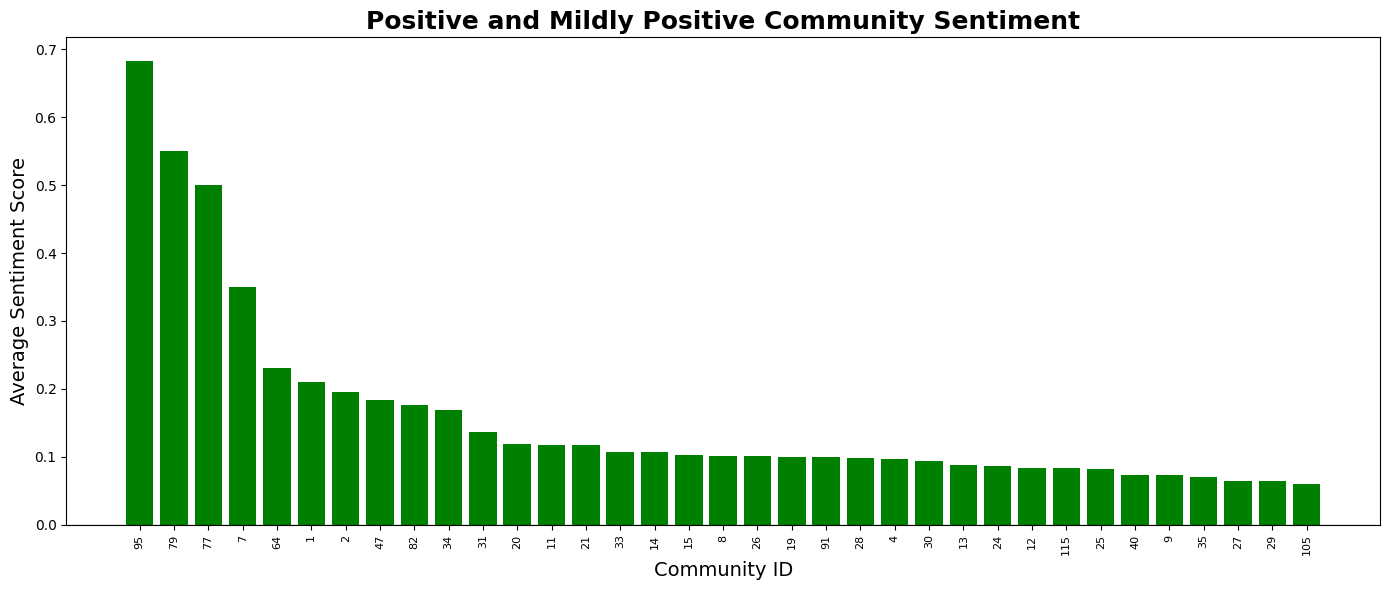

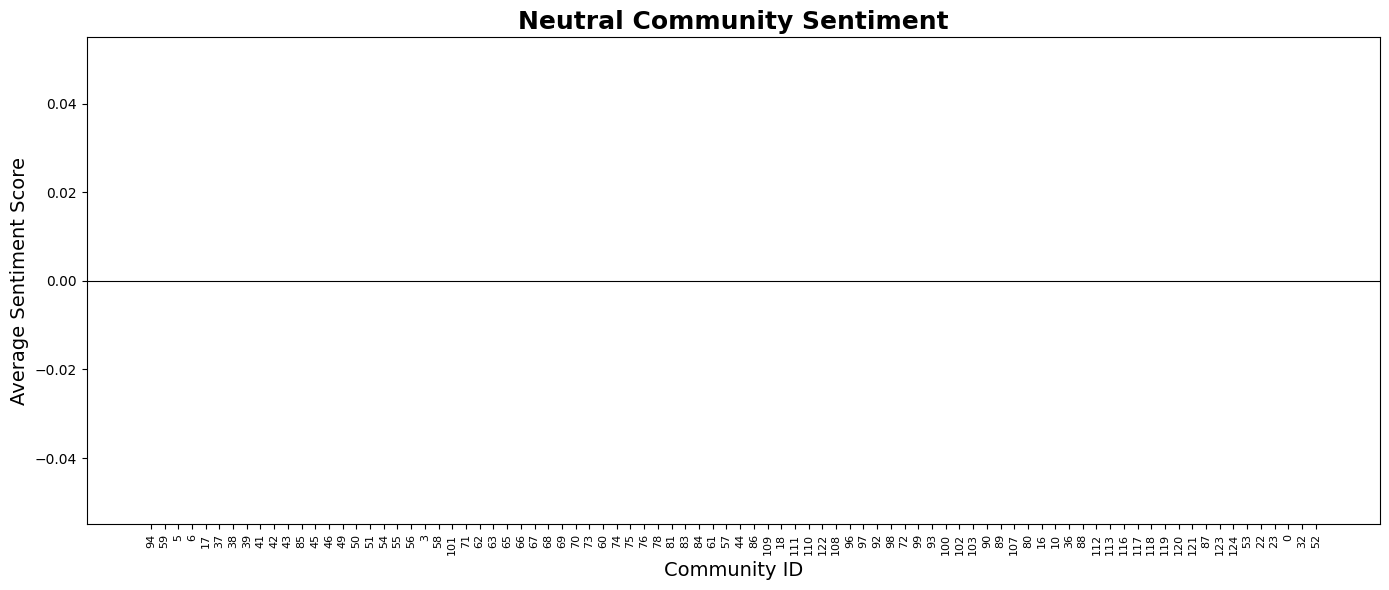

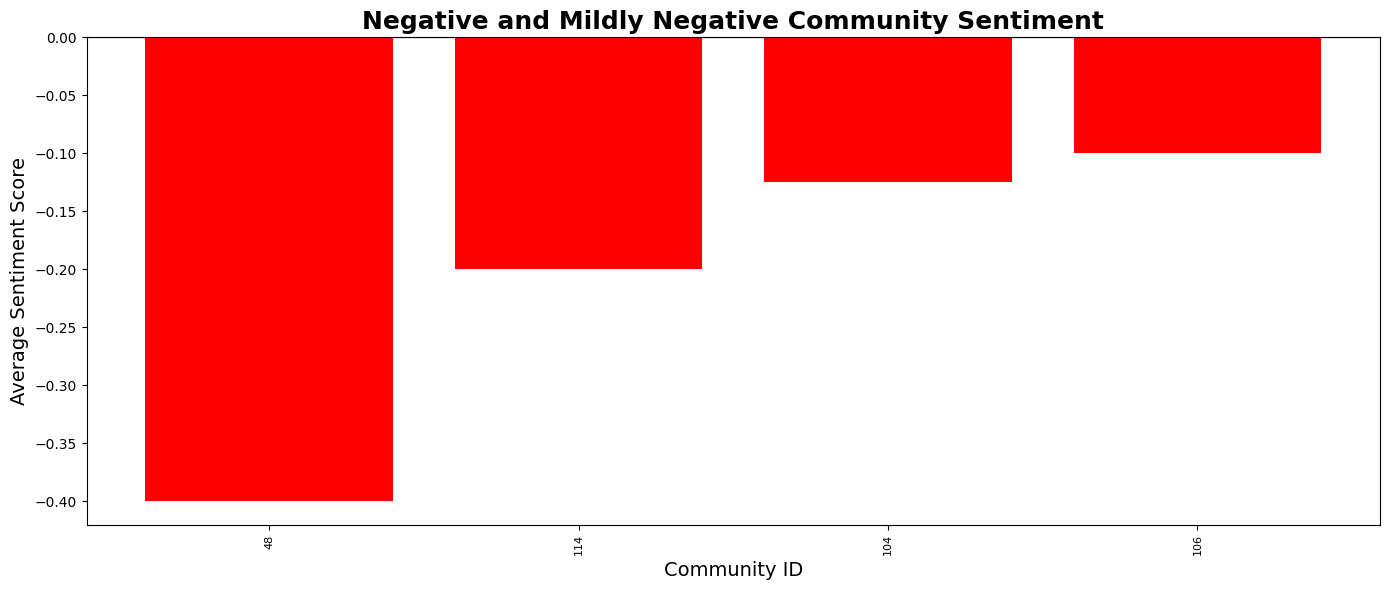

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('classified_community_sentiment.csv')

# Split based on sentiment label
positive_df = df[df['sentiment_label'].isin(['Positive', 'Mildly Positive'])]
neutral_df = df[df['sentiment_label'] == 'Neutral']
negative_df = df[df['sentiment_label'].isin(['Mildly Negative', 'Negative'])]

# Sorting for clear visualization
positive_df = positive_df.sort_values(by='average_sentiment', ascending=False)
neutral_df = neutral_df.sort_values(by='average_sentiment', ascending=False)
negative_df = negative_df.sort_values(by='average_sentiment', ascending=True)

# Plot function
def plot_sentiment(df, title, color, filename):
    plt.figure(figsize=(14, 6))
    plt.bar(df['community'].astype(str), df['average_sentiment'], color=color)
    plt.title(title, fontsize=18, fontweight='bold')
    plt.xlabel('Community ID', fontsize=14)
    plt.ylabel('Average Sentiment Score', fontsize=14)
    plt.xticks(rotation=90, fontsize=8)
    plt.axhline(0, color='black', linewidth=0.8)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# Plot Positive Sentiments
plot_sentiment(positive_df, 'Positive and Mildly Positive Community Sentiment', 'green', 'positive_communities_sentiment.png')

# Plot Neutral Sentiments
plot_sentiment(neutral_df, 'Neutral Community Sentiment', 'gray', 'neutral_communities_sentiment.png')

# Plot Negative Sentiments
plot_sentiment(negative_df, 'Negative and Mildly Negative Community Sentiment', 'red', 'negative_communities_sentiment.png')


In [50]:
import networkx as nx
import pandas as pd

# Load the graph
G = nx.read_graphml("user_interaction_graph_with_communities.graphml")

# Compute centralities
pagerank = nx.pagerank(G)
betweenness = nx.betweenness_centrality(G)
degree = nx.degree_centrality(G)
community = nx.get_node_attributes(G, "community")

# Combine into a DataFrame
records = []
for node in G.nodes():
    records.append({
        "user": node,
        "community": community.get(node),
        "pagerank": pagerank.get(node),
        "betweenness": betweenness.get(node),
        "degree": degree.get(node)
    })

df = pd.DataFrame(records)

# Save
df.to_csv("community_influencers_and_bridges.csv", index=False)
print("Saved: community_influencers_and_bridges.csv")



✅ Saved: community_influencers_and_bridges.csv

🔗 Top Bridge Users Between Clusters:
                      user  community  betweenness
1968         automoderator          4     0.009679
2226      daydream_machine          8     0.005234
2023                frajer          8     0.004050
2188         impeccabletim         33     0.002505
2122               enburgi         26     0.002460
2132                mcfw31         24     0.002440
2575               hekna02         11     0.001723
1972           backupsaway         13     0.001595
2001             coleshane          9     0.001451
2000            siphenprax         25     0.001347
2423     purplespacesurfer         15     0.001341
3166              racloves         19     0.000967
3961               augggie          8     0.000859
2644                ss2811          4     0.000685
2304         pinkcadillacs         21     0.000559
2889          ipodnano2003         24     0.000550
2116        droobidoobidoo         19     0.0005

In [54]:

# Print Top Influencers (PageRank)
print("Top 10 Influencers by PageRank:\n")
top_influencers = df.sort_values(by="pagerank", ascending=False).head(10)
for i, row in top_influencers.iterrows():
    print(f"{row['user']:<25} | Community: {row['community']} | PageRank: {row['pagerank']:.5f}")

# Print Top Bridges (Betweenness)
print("\n Top 10 Bridges by Betweenness Centrality:\n")
top_bridges = df.sort_values(by="betweenness", ascending=False).head(10)
for i, row in top_bridges.iterrows():
    print(f"{row['user']:<25} | Community: {row['community']} | Betweenness: {row['betweenness']:.5f}")


Top 10 Influencers by PageRank:

springtimecarnivore       | Community: 29 | PageRank: 0.04490
king81arthur              | Community: 2 | PageRank: 0.04085
big-ambitions-8258        | Community: 26 | PageRank: 0.03876
georgeneleggett           | Community: 2 | PageRank: 0.03133
impeccabletim             | Community: 33 | PageRank: 0.02651
mcfw31                    | Community: 24 | PageRank: 0.02286
enburgi                   | Community: 26 | PageRank: 0.01705
northern89lights          | Community: 2 | PageRank: 0.01658
augggie                   | Community: 8 | PageRank: 0.01451
purplespacesurfer         | Community: 15 | PageRank: 0.01196

 Top 10 Bridges by Betweenness Centrality:

automoderator             | Community: 4 | Betweenness: 0.00968
daydream_machine          | Community: 8 | Betweenness: 0.00523
frajer                    | Community: 8 | Betweenness: 0.00405
impeccabletim             | Community: 33 | Betweenness: 0.00251
enburgi                   | Community: 26 | Betwe

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the centrality data
df = pd.read_csv('community_influencers_and_bridges.csv')

# Sort and select Top N
N = 10
top_degree = df.sort_values(by='degree', ascending=False).head(N)
top_pagerank = df.sort_values(by='pagerank', ascending=False).head(N)
top_betweenness = df.sort_values(by='betweenness', ascending=False).head(N)

# Plotting function
def plot_centrality(data, metric, color, title):
    plt.figure(figsize=(10,6))
    plt.barh(data['user'], data[metric], color=color)
    plt.xlabel(metric.capitalize())
    plt.ylabel('User')
    plt.title(title)
    plt.gca().invert_yaxis()  # Highest at top
    plt.tight_layout()
    plt.show()

# Plot Degree Centrality
    

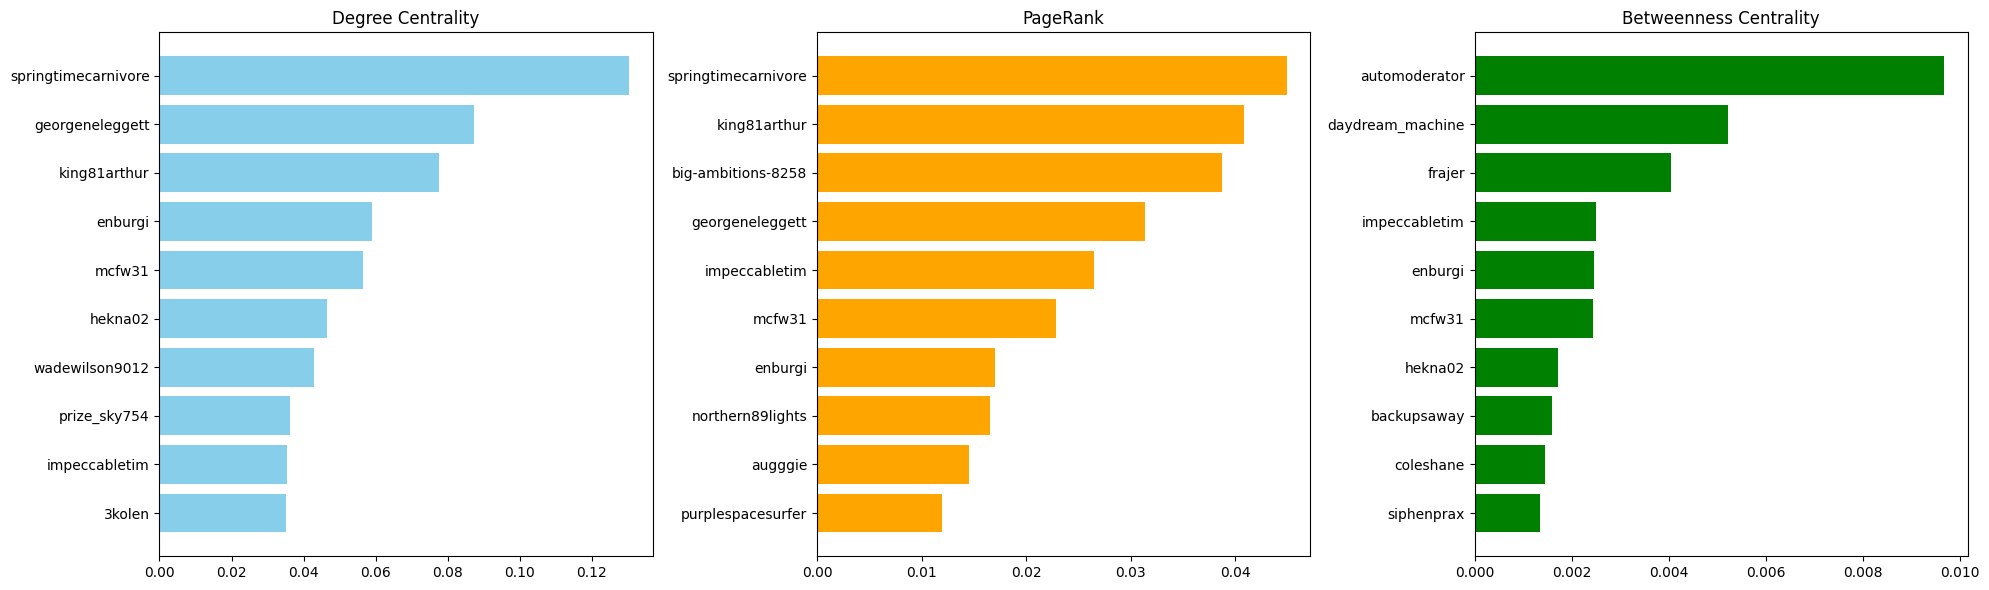

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Degree Centrality
axs[0].barh(top_degree['user'], top_degree['degree'], color='skyblue')
axs[0].set_title('Degree Centrality')
axs[0].invert_yaxis()

# PageRank
axs[1].barh(top_pagerank['user'], top_pagerank['pagerank'], color='orange')
axs[1].set_title('PageRank')
axs[1].invert_yaxis()

# Betweenness Centrality
axs[2].barh(top_betweenness['user'], top_betweenness['betweenness'], color='green')
axs[2].set_title('Betweenness Centrality')
axs[2].invert_yaxis()

plt.tight_layout()
plt.show()


In [44]:
import networkx as nx

# Load your existing directed graph
G_directed = nx.read_graphml("user_interaction_graph.graphml")

# Convert to undirected 
G_undirected = nx.Graph()

for u, v, data in G_directed.edges(data=True):
    if G_undirected.has_edge(u, v):
        G_undirected[u][v]["weight"] += 1
    else:
        G_undirected.add_edge(u, v, **data)
        G_undirected[u][v]["weight"] = 1  

# Preserve node attributes (like 'community')
for node, attrs in G_directed.nodes(data=True):
    G_undirected.nodes[node].update(attrs)

# Save the undirected graph
nx.write_graphml(G_undirected, "user_interaction_graph_undirected.graphml")

print("Saved: user_interaction_graph_undirected.graphml")


✅ Saved: user_interaction_graph_undirected.graphml


In [45]:
import pandas as pd
from datetime import datetime

# Load your data
df = pd.read_csv("sabrina_cleaned_combined.csv", encoding='ISO-8859-1')

# Convert 'comment_created_utc' to year
df['year'] = pd.to_datetime(df['comment_created_utc'], unit='s').dt.year

# Also extract month for monthly graph
# df['month'] = pd.to_datetime(df['comment_created_utc'], unit='s').dt.month


/var/folders/5p/w6nqq1vn54n8dgr2px7b4dcc0000gn/T/ipykernel_5146/1760484531.py:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("sabrina_cleaned_combined.csv", encoding='ISO-8859-1')


In [47]:
import pandas as pd
import networkx as nx
from datetime import datetime

# Load Data
df = pd.read_csv("sabrina_cleaned_combined.csv", encoding='ISO-8859-1')

# Clean & Drop Deleted Users
df = df[
    df['comment_author'].notna() &
    df['post_author'].notna() &
    ~df['comment_author'].str.lower().isin(['[deleted]', 'deleted']) &
    ~df['post_author'].str.lower().isin(['[deleted]', 'deleted'])
]

# Convert Timestamp to Year
df['year'] = pd.to_datetime(df['comment_created_utc'], unit='s').dt.year

# Identify Available Years 
years = df['year'].dropna().unique()

# Build Graphs Year by Year
for year in sorted(years):
    G = nx.Graph()  

    df_year = df[df['year'] == year]

    for _, row in df_year.iterrows():
        source = str(row['comment_author']).strip().lower()
        if pd.notnull(row.get('parent_comment_author')):
            target = str(row['parent_comment_author']).strip().lower()
        else:
            target = str(row['post_author']).strip().lower()

        if source and target and source != target:
            G.add_edge(source, target,
                       text=row.get('cleaned_text', ''),
                       subreddit=row.get('subreddit', ''),
                       year=year)

            # retain node-level metadata if you want
            G.nodes[source]["year"] = year
            G.nodes[target]["year"] = year

    # Save the graph if not empty
    if G.number_of_edges() > 0:
        output_file = f"user_interaction_graph_{year}.graphml"
        nx.write_graphml(G, output_file)
        print(f"Saved: {output_file} ({G.number_of_nodes()} nodes, {G.number_of_edges()} edges)")


/var/folders/5p/w6nqq1vn54n8dgr2px7b4dcc0000gn/T/ipykernel_5146/1796533547.py:6: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("sabrina_cleaned_combined.csv", encoding='ISO-8859-1')


✅ Saved: user_interaction_graph_2023.0.graphml (83 nodes, 78 edges)
✅ Saved: user_interaction_graph_2024.0.graphml (1316 nodes, 1673 edges)
✅ Saved: user_interaction_graph_2025.0.graphml (5945 nodes, 10174 edges)


In [55]:
import networkx as nx
import community as community_louvain
import os

# Path where yearly graphs are stored
graph_folder = "./"  # adjust if your graphs are in another folder

# List all your yearly files
yearly_files = [f"user_interaction_graph_{year}.0.graphml" for year in range(2023, 2026)]  # 2023, 2024, 2025

# Apply Louvain for each year
for file in yearly_files:
    if not os.path.exists(os.path.join(graph_folder, file)):
        print(f"File {file} not found, skipping...")
        continue

    print(f"Processing {file}...")

    # Load graph
    G = nx.read_graphml(os.path.join(graph_folder, file))

    # Convert to undirected if not already
    if G.is_directed():
        G = G.to_undirected()

    # Apply Louvain
    partition = community_louvain.best_partition(G)

    # Set node attribute
    nx.set_node_attributes(G, partition, "community")

    # Save updated graph
    output_file = file.replace(".graphml", "_with_louvain.graphml")
    nx.write_graphml(G, os.path.join(graph_folder, output_file))

    num_communities = len(set(partition.values()))
    print(f"Louvain applied to {file}. Detected {num_communities} communities.")


📂 Processing user_interaction_graph_2023.0.graphml...
✅ Louvain applied to user_interaction_graph_2023.0.graphml. Detected 10 communities.
📂 Processing user_interaction_graph_2024.0.graphml...
✅ Louvain applied to user_interaction_graph_2024.0.graphml. Detected 16 communities.
📂 Processing user_interaction_graph_2025.0.graphml...
✅ Louvain applied to user_interaction_graph_2025.0.graphml. Detected 35 communities.
